### Pipeline

In [ ]:
import pandas as pd
import string
import re
import json
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Preprocessing class (same as you've defined)
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open('../data/vietnamese.txt', 'r', encoding='utf-8') as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open('../data/vi-abbreviations.json', 'r', encoding='utf-8') as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r'\s+', ' ', x)
        x = re.sub(r'[^\w\s]', '', x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans('', '', string.punctuation))

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using TextBlob."""
        return str(TextBlob(x).correct())

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return word_tokenize(x)

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return ' '.join([word for word in x.split() if word not in self.stop_words])

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return ' '.join([self.abbreviations.get(word, word) for word in x.split()])
    
    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)
        x = self.replace_abbreviations(x)  # Apply abbreviation replacement
        return x

# Initialize the VietnamesePreprocessing class with the abbreviation dictionary
preprocessor = VietnamesePreprocessing()

# Read your CSV file
df = pd.read_csv('../data/phone_ratings.csv')

# Delete row which have empty comment
df = df[df['comment'] != '']

# Remove row with comment have less than 1 character
df = df[df['comment'].notna()]  # Ensure there are no NaN values
df = df[df['comment'].astype(str).apply(lambda x: len(x) > 1)] 

# Apply preprocessing to the 'comment' column (or whichever column you want to process)
df['comment'] = df['comment'].astype(str).apply(preprocessor)

# Join all processed comments into a single text
all_comments = ' '.join(df['comment'])

### Phân tích số lượng từ

In [2]:
df.head()

,product_id,comment,rating,source_file
0,honor-x8b,đừng mua không có linh kiện,1,ratings\honor-x8b.csv
1,honor-x8b,máy sao cũng được ghét nhất cái Zalo vui nó bá...,3,ratings\honor-x8b.csv
2,honor-x8b,chiếc điện thoại mỏng nhất tôi từng dùng cũng ...,5,ratings\honor-x8b.csv
3,honor-x8b,sao hôm tôi mua lại không được tặng tai nghe n...,4,ratings\honor-x8b.csv
4,honor-x8b,em mua được một tuần trả lại mất bao nhiêu ạ,3,ratings\honor-x8b.csv


In [3]:
df.shape

(2313, 4)

In [4]:
df["word_count"] = df["comment"].astype(str).apply(lambda x: len(x.split()))

In [5]:
df[["comment", "word_count"]].sort_values(by="word_count", ascending=False).head()

,comment,word_count
1864,sau hơn một tháng sử dụng có những ưu nhược đi...,490
1428,thấy không ổn ở chổ định vị thời tiết ở trà cổ...,380
1306,máy thiết kế đẹp độ hoàn thiện rất tốt mặt trư...,284
623,một nhân viên bán điện thoại thì rất nhiệt tìn...,270
1684,trước tiên mình đánh giá cao sản phẩm của sams...,239


### Biểu đồ tần suất

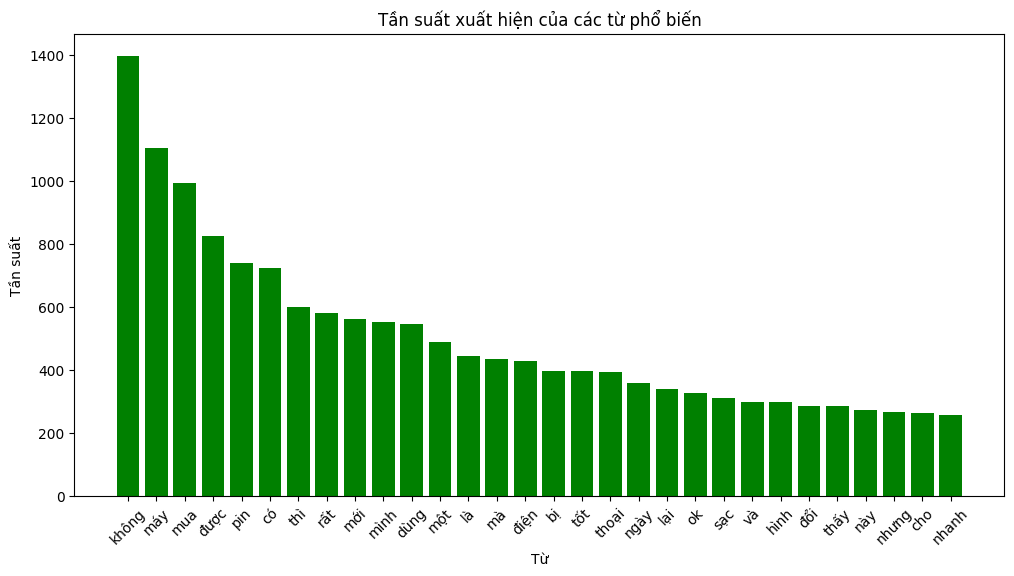

In [6]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất
 
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='green')
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

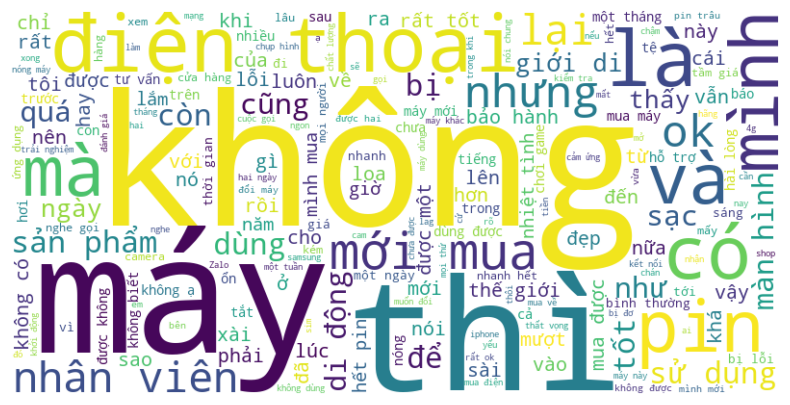

In [7]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for word cloud
plt.show()

In [8]:
df.to_csv('../data/phone_ratings_cleaned.csv', index=False)